# Variance Comparisons

The following codes generate the figures shown in my lab seminar presentation.

In [4]:
library(dplyr)
library(rstan)
library(ggplot2)
library(ggpubr)
library(gridExtra)
library(xtable)

options(repr.plot.width = 10, repr.plot.height = 7)
group.colors <- c("JS+" = "#e91010", "Naive" = "#000000", "RB" ="#1c97e3", "RB+" = "#1cbd47")

source("logitregress.R")


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: StanHeaders


rstan version 2.32.6 (Stan version 2.32.2)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)



Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine


Loading required package: mvtnorm

Loading required package: randtoolbox

Loading required package: rngWELL

This is randtoolbox. For an overview, type 'help("randtoolbox")'.

Loading required package: distr

Loading required packa

## Variance Comparisons Between Naive, Rao-Blackwellized, and James-Stein Estimators

We will be performing the estimation repeatedly, to get a controlled Monte Carlo sample of the inherent variances in the estimators being compared.

**Don't Run The Next Cell Unless Updating Results** Total expected run is at 3000 min.

In [5]:
niter <- 200
sampsize <- 200
mc_size <- 1000

all_coeffs <- seq(from = -2, to = 2, length = 9)

In [126]:
all.variances <- NULL
all.iterations <- list(10)

for(seed in 0:9){

    for(K in 2:10){
        
        d <- generate_logit(sampsize, beta_coeff = all_coeffs[1:K], seed = seed)

        p <- ncol(d$samp)
        n <- nrow(d$samp)
        priors <- unpack_priors(NULL)
        seq_p <- 1:(p+1)

        coef_params <- paste0("beta_1_", seq_p)
        shape_params  <- paste0("alpha_star_", seq_p)
        rate_params <- paste0("beta_star_", seq_p)

        set.seed(seed)
        params <- list(2)
        params[[1]] <- data.frame(t(c(
            rep(0, times = p + 1), # beta_1
            rep(2, times = p + 1), # alpha_star
            rep(3, times = p + 1)  # beta_star
        )))

        param_names <- c(coef_params, shape_params, rate_params)
        colnames(params[[1]]) <- param_names
        iters <- list(niter)
        for(i in 1:niter){
            if(i %% 50 == 0) message(paste0("Mixture Components: ", K, "; Iteration: ", i, "/", niter))
    
            old.params <- params[[1]]
            dat.nav <- generate_samples(S = mc_size, d$categories, d$samp, old.params, priors, method="Naive")
            dat.rbl <- generate_samples(S = mc_size, d$categories, d$samp, old.params, priors, method="RB")
            dat.jsp <- generate_samples(S = mc_size, d$categories, d$samp, old.params, priors, method="JS+")
            dat.rbp <- generate_samples(S = mc_size, d$categories, d$samp, old.params, priors, method="RB+")

            bbvi.all <- rbind(
                generate_bbvi(dat.nav),
                generate_bbvi(dat.rbl),
                generate_bbvi(dat.jsp),
                generate_bbvi(dat.rbp)
            )

            iters[[i]] <- data.frame(
                method = c("Naive","RB","JS+","RB+"),
                bbvi.all
            )
        }

        mse <- do.call('rbind', iters)
        par.variances <- aggregate(. ~ method, data = mse, var)
        all.variances <- rbind(all.variances,
            data.frame(
                params = ncol(mse) - 1,
                method = par.variances[,1],
                var = apply(par.variances[,-1], 1, min)
            )
        )
    }

}

saveRDS(all.variances, "Outputs/all_logit_variances.RDS")

Mixture Components: 2; Iteration: 50/200

Mixture Components: 2; Iteration: 100/200

Mixture Components: 2; Iteration: 150/200

Mixture Components: 2; Iteration: 200/200

Mixture Components: 3; Iteration: 50/200

Mixture Components: 3; Iteration: 100/200

Mixture Components: 3; Iteration: 150/200

Mixture Components: 3; Iteration: 200/200

Mixture Components: 4; Iteration: 50/200

Mixture Components: 4; Iteration: 100/200

Mixture Components: 4; Iteration: 150/200

Mixture Components: 4; Iteration: 200/200

Mixture Components: 5; Iteration: 50/200

Mixture Components: 5; Iteration: 100/200

Mixture Components: 5; Iteration: 150/200

Mixture Components: 5; Iteration: 200/200

Mixture Components: 6; Iteration: 50/200

Mixture Components: 6; Iteration: 100/200

Mixture Components: 6; Iteration: 150/200

Mixture Components: 6; Iteration: 200/200

Mixture Components: 7; Iteration: 50/200

Mixture Components: 7; Iteration: 100/200

Mixture Components: 7; Iteration: 150/200

Mixture Component

`summarise()` has grouped output by 'params'. You can override using the
`.groups` argument.


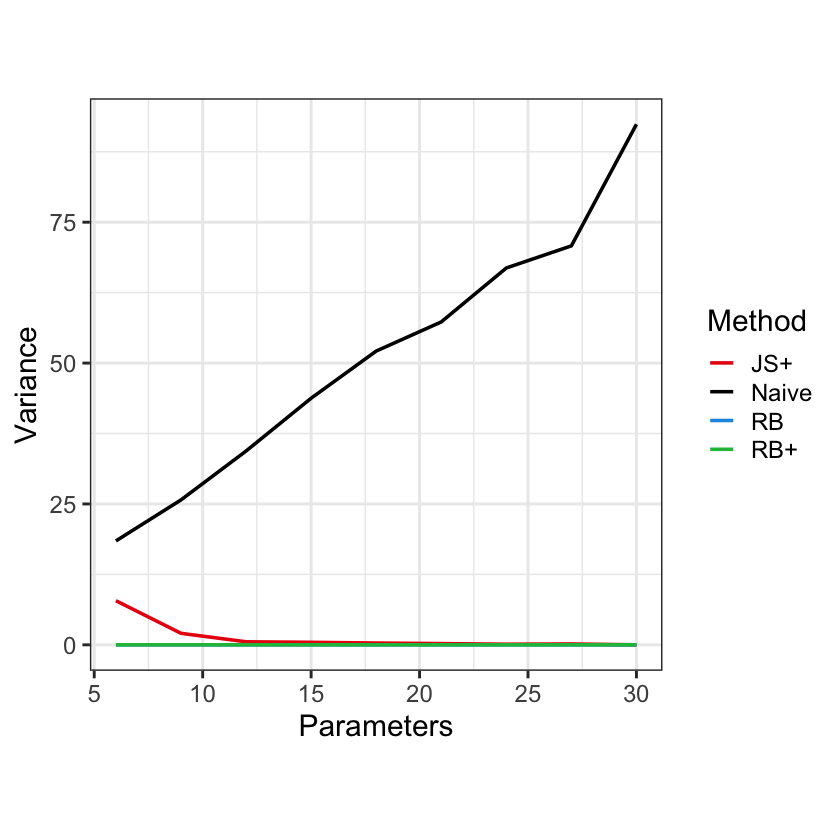

In [36]:
all.variances <- readRDS("Outputs/all_logit_variances.RDS")

vars <- all.variances %>%
    group_by(params, method) %>%
    summarise(mean = mean(var), sd = sd(var))
    
    
p1 <- vars %>%
    ggplot(aes(params, mean, fill = method)) +
    geom_line(data = vars, aes(color = method), linewidth = 1) + 
    scale_color_manual(values = group.colors, name = "Method") +
    labs(x = "Parameters", y = "Variance") +
    theme_bw(base_size=18) +
    theme(aspect.ratio = 1)

options(repr.plot.width = 7, repr.plot.height = 7)
p1

## Using The BBVI Algorithm

This time we create the BBVI Algorithm In A Sample Dataset with K = 2 Components.

In [12]:
set.seed(923)
d <- generate_logit(sampsize, beta_coeff = all_coeffs[1:2], vars = c(1), seed = 0)

In [14]:
seeds <- 0:9
all.elbo <- list(length(seeds))
all.params <- list(length(seeds))

for(i in seq_along(seeds)){
    samp.nav <- bbvi_logitreg(categories = d$categories, X = scale(d$samp), learn_rate = rate_rmsprop(1, 0.999), converge=1e-3, mc_size = 500, min_iter = 500, max_iter = 500, method = "Naive", verbose = TRUE, seed = seeds[i])
    samp.rbl <- bbvi_logitreg(categories = d$categories, X = scale(d$samp), learn_rate = rate_rmsprop(1, 0.999), converge=1e-3, mc_size = 500, min_iter = 500, max_iter = 500, method = "RB", verbose = TRUE, seed = seeds[i])
    samp.jsp <- bbvi_logitreg(categories = d$categories, X = scale(d$samp), learn_rate = rate_rmsprop(1, 0.999), converge=1e-3, mc_size = 500, min_iter = 500, max_iter = 500, method = "JS+", verbose = TRUE, seed = seeds[i])
    samp.rbp <- bbvi_logitreg(categories = d$categories, X = scale(d$samp), learn_rate = rate_rmsprop(1, 0.999), converge=1e-3, mc_size = 500, min_iter = 500, max_iter = 500, method = "RB+", verbose = TRUE, seed = seeds[i])

    all.elbo[[i]] <- bind_rows(
        samp.nav$elbo %>% mutate(method = "Naive"),
        samp.rbl$elbo %>% mutate(method = "RB"),
        samp.jsp$elbo %>% mutate(method = "JS+"),
        samp.rbp$elbo %>% mutate(method = "RB+")
    )

    all.params[[i]] <- bind_rows(
        samp.nav$trace %>% mutate(iter = 1:500, method = "Naive"),
        samp.rbl$trace %>% mutate(iter = 1:500, method = "RB"),
        samp.jsp$trace %>% mutate(iter = 1:500, method = "JS+"),
        samp.rbp$trace %>% mutate(iter = 1:500, method = "RB+")
    )
}

all.elbo <- do.call('rbind', all.elbo)
all.params <- do.call('rbind', all.params)

saveRDS(all.elbo, "Outputs/all_logit_elbo.RDS")
saveRDS(all.params, "Outputs/all_logit_params.RDS")

BBVI-Naive: Iteration 100 | lambda: 0.0208 | ELBO: -973.54 | ELBO Change: 0

BBVI-Naive: Iteration 200 | lambda: 0.0246 | ELBO: -974.49 | ELBO Change: 0

BBVI-Naive: Iteration 300 | lambda: 0.028 | ELBO: -987.49 | ELBO Change: 0

BBVI-Naive: Iteration 400 | lambda: 0.02 | ELBO: -973.68 | ELBO Change: 0

BBVI-Naive: Iteration 500 | lambda: 0.0094 | ELBO: -975.95 | ELBO Change: 0

Algorithm did not converge after 500 steps. Results may not be reliable.

BBVI-RB: Iteration 100 | lambda: 0.0486 | ELBO: -978.4 | ELBO Change: 0

BBVI-RB: Iteration 200 | lambda: 0.006 | ELBO: -962.67 | ELBO Change: 0

BBVI-RB: Iteration 300 | lambda: 0.0472 | ELBO: -967.85 | ELBO Change: 0

BBVI-RB: Iteration 400 | lambda: 0.0329 | ELBO: -936.85 | ELBO Change: 0

BBVI-RB: Iteration 500 | lambda: 0.0174 | ELBO: -898.38 | ELBO Change: 0

Algorithm did not converge after 500 steps. Results may not be reliable.

BBVI-JS+: Iteration 100 | lambda: 0.0228 | ELBO: -950.46 | ELBO Change: 0

BBVI-JS+: Iteration 200 | l

`summarise()` has grouped output by 'iter'. You can override using the
`.groups` argument.
Warning message:
"Removed 196 rows containing missing values or values outside the scale range
(`geom_line()`)."


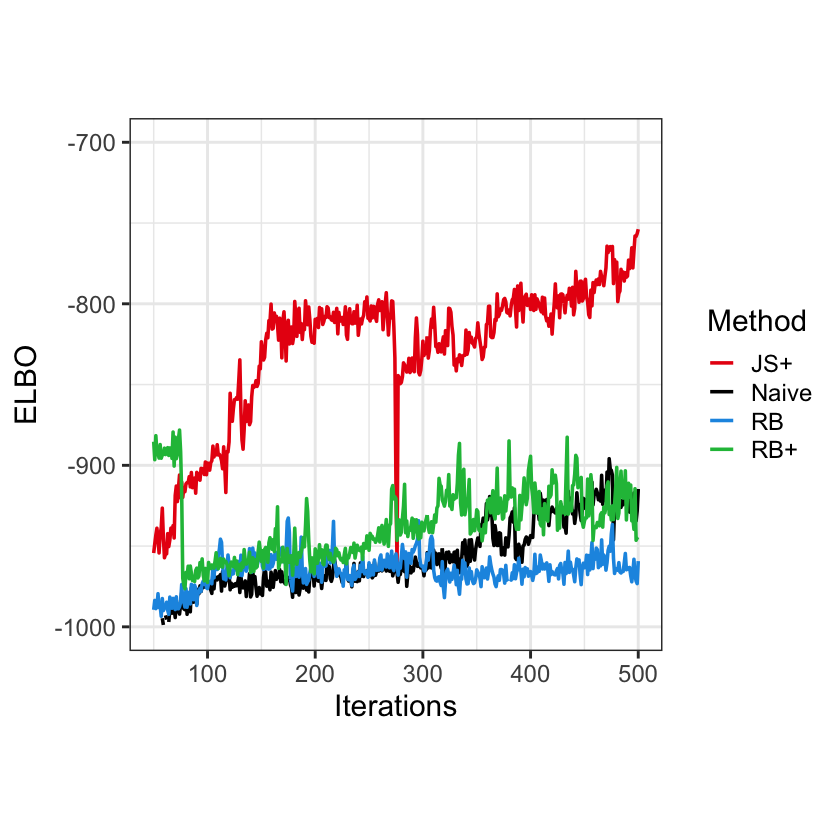

In [35]:
all.elbo <- readRDS("Outputs/all_logit_elbo.RDS")

elbo.iters <- all.elbo %>%
    group_by(iter, method) %>%
    summarise(mean = mean(elbo), sd = sd(elbo)) %>%
    filter(method %in% c("Naive","JS+","RB","RB+"))

p2 <- elbo.iters %>%
    ggplot(aes(iter, mean, fill = method)) +
    geom_line(data = elbo.iters, aes(color = method), linewidth = 1) + 
    scale_color_manual(values = group.colors, name = "Method") +
    scale_y_continuous(limits = c(-1000, -700)) +
    scale_x_continuous(limits = c(50, 500)) +
    labs(x = "Iterations", y = "ELBO") +
    theme_bw(base_size=18) +
    theme(aspect.ratio = 1)

options(repr.plot.width = 7, repr.plot.height = 7)
p2

In [7]:
varMax <- function (var){
    sapply(var, function(x) ifelse(x >= 0, x, 0))
}

`summarise()` has grouped output by 'iter'. You can override using the
`.groups` argument.


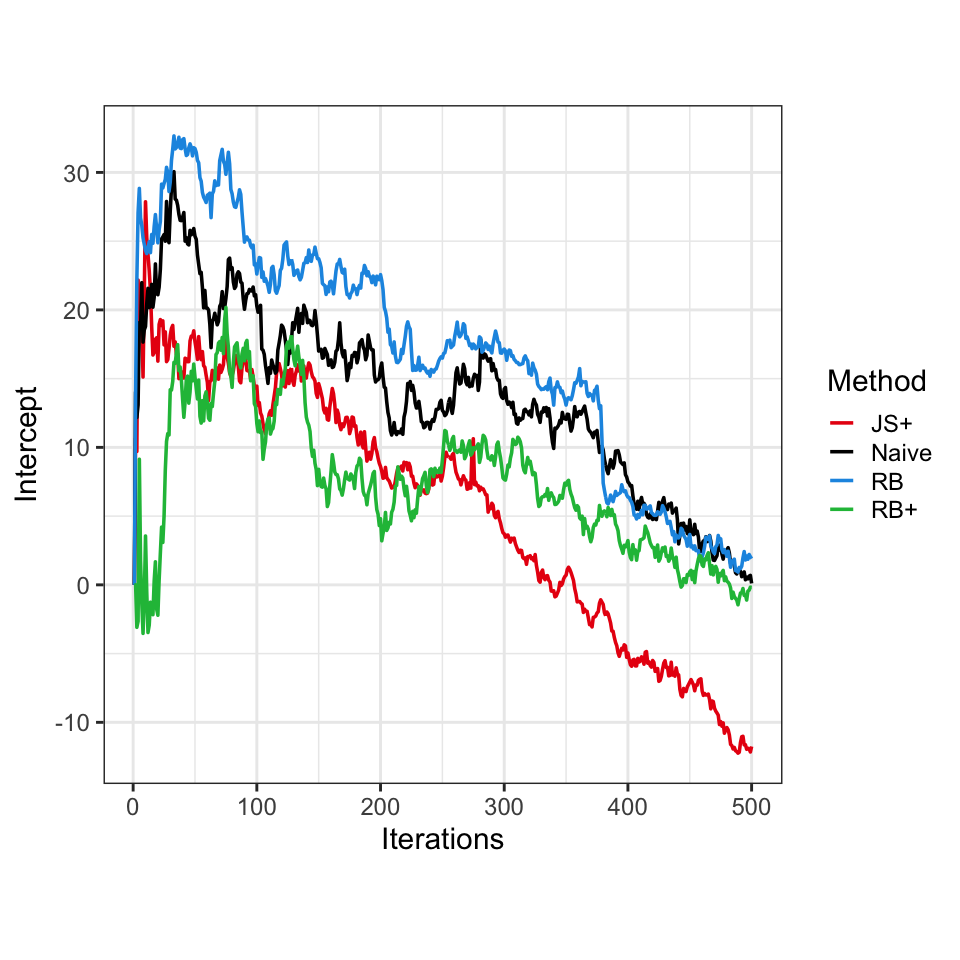

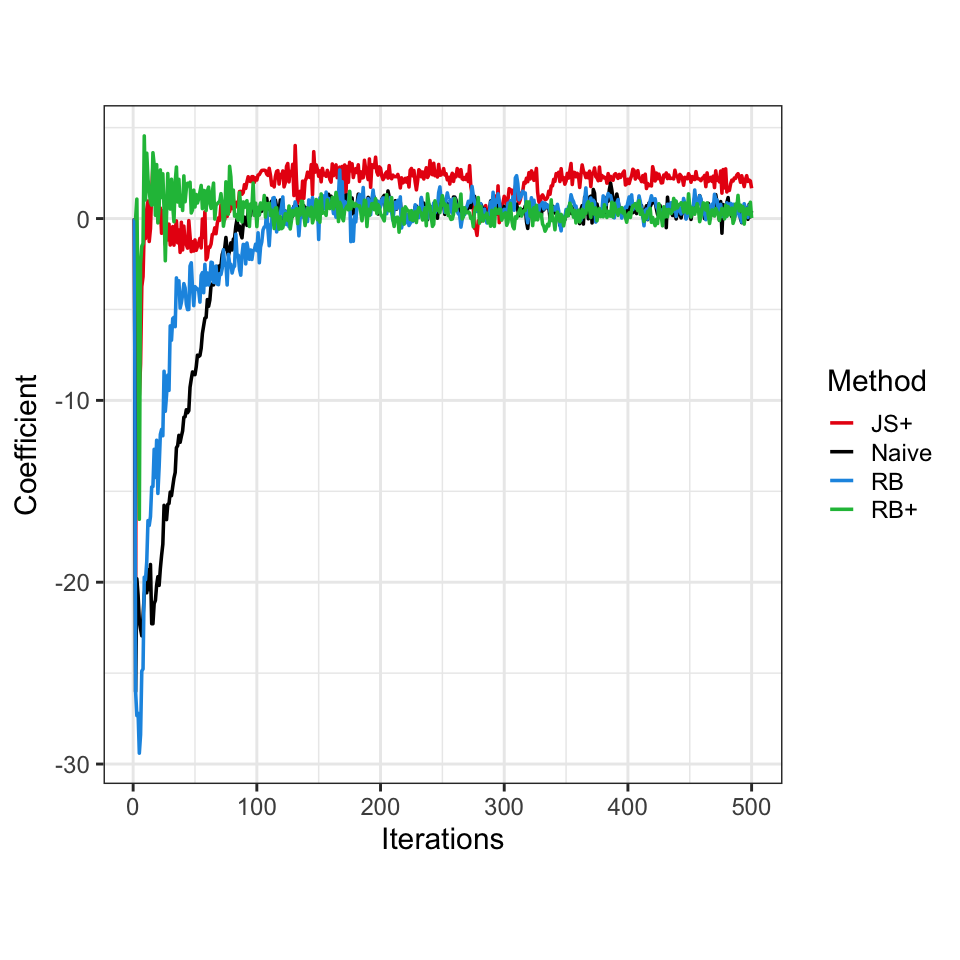

In [44]:
all.params <- readRDS("Outputs/all_logit_params.RDS")

coeffs <- all.params %>%
    group_by(iter, method) %>%
    summarise(beta_1 = mean(beta_1_1), beta_2 = mean(beta_1_2), sd1 = sd(beta_1_1), sd2 = sd(beta_1_2)) %>%
    filter(method %in% c("Naive","JS+","RB","RB+"))
    
p3 <- coeffs %>%
    ggplot(aes(iter, beta_1, fill = method)) +
    geom_line(data = coeffs, aes(color = method), linewidth = 1) + 
    scale_color_manual(values = group.colors, name = "Method") +
    labs(x = "Iterations", y = "Intercept") +
    theme_bw(base_size=18) +
    theme(aspect.ratio = 1)

p4 <- coeffs %>%
    ggplot(aes(iter, beta_2, fill = method)) +
    geom_line(data = coeffs, aes(color = method), linewidth = 1) + 
    scale_color_manual(values = group.colors, name = "Method") +
    labs(x = "Iterations", y = "Coefficient") +
    theme_bw(base_size=18) +
    theme(aspect.ratio = 1)

p3
p4

## Plots Appearing In Paper

The following generates the plots that appear in the paper

Warning message:
"Removed 196 rows containing missing values or values outside the scale range
(`geom_line()`)."


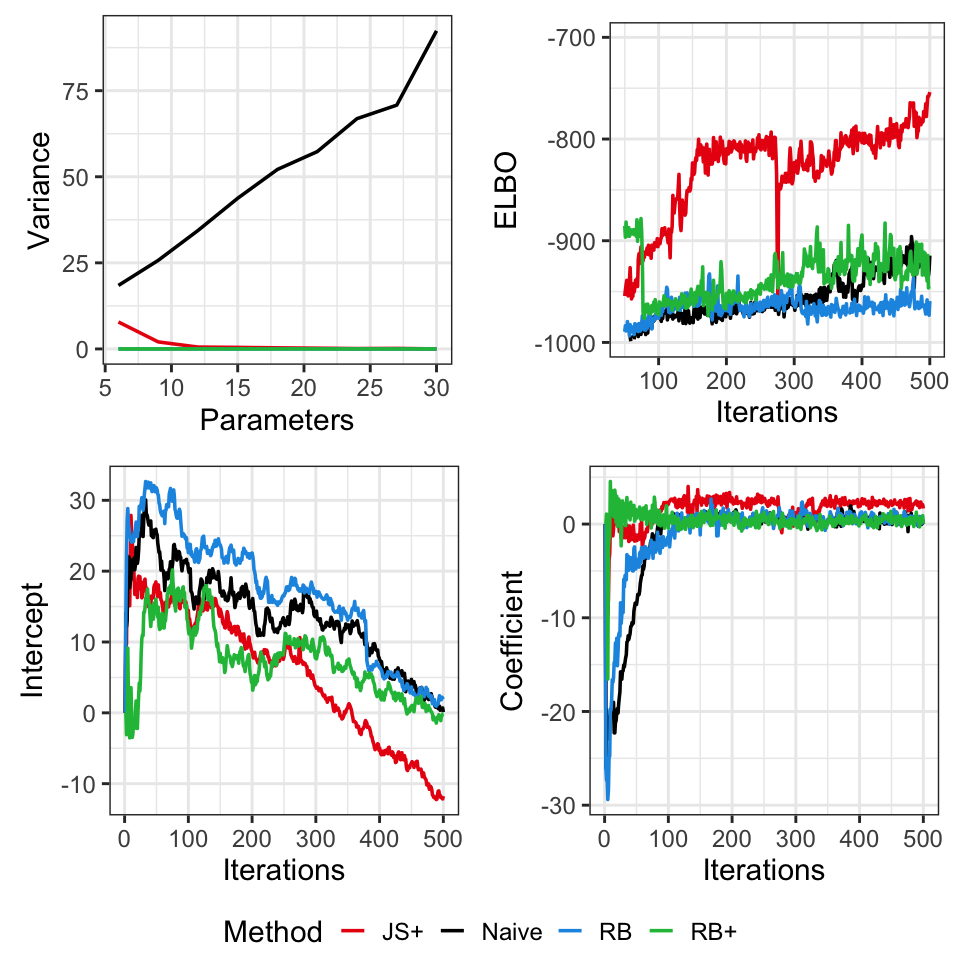

In [45]:
options(repr.plot.width = 8, repr.plot.height = 8)
ggarrange(p1, p2, p3, p4, nrow = 2, ncol = 2, common.legend = TRUE, legend = "bottom")